# 基于LangGraph的智能深度研究代理

## 需求分析

在当今信息爆炸的时代，研究人员、学生和分析师在进行深度课题研究时面临着严峻的挑战。传统的“人工研究”模式存在以下痛点：

1. **耗时巨大 (Time-Consuming)**: 手动搜索、筛选、阅读和整合大量文献资料是一个极其耗时的过程，占据了研究人员大部分的精力。
2. **信息过载 (Information Overload)**: 面对海量的网络信息，如何快速识别高质量、高相关性的内容成为一大难题。研究者容易迷失在信息的海洋中，效率低下。
3. **综合困难 (Difficulty in Synthesis)**: 将来自不同来源、不同视角的信息进行有效整合，形成一个逻辑清晰、观点明确的综合报告，对研究者的认知能力要求极高，且容易产生主观偏见。
4. **交互性差 (Poor Interactivity)**: 传统研究工具是单向的。研究者无法与研究过程进行动态交互，例如在初步计划后进行调整，或对中间结果提出反馈。

我们的智能深度研究代理旨在解决以上痛点。它利用大型语言模型（LLM）的强大能力，将复杂的研究任务自动化，通过多轮交互让用户参与和指导研究过程，最终高效地生成一份结构化、有深度的研究报告。

### 系统架构

我们将整个研究流程拆分为多个职责清晰、可复用的智能体节点，并通过 LangGraph 将它们编排为一条闭环的自动化研究链路。

1. **Planner（规划器）**
- **输入**：用户给定的研究目标。  
- **功能**：调用 LLM 将目标转化为结构化研究计划，拆分成若干可执行的子任务。  
- **输出**：更新状态，生成子任务列表。

2. **Task_Splitter（任务分解器）**
- **输入**：完整研究计划。  
- **功能**：将整体研究问题进一步细化，生成针对每个子任务的检索查询。  
- **输出**：结构化的查询请求。

3. **Content_Searcher（内容搜索器）**
- **输入**：结构化查询请求。  
- **功能**：通过搜索接口（如 Tavily API）检索相关网页，获取原始资料链接与摘要。  
- **输出**：原始搜索结果集合。

4. **Content_Enhancer（内容增强器）**
- **输入**：搜索结果。  
- **功能**：提取网页正文、去除干扰信息，保留可供后续加工的核心文本数据。  
- **输出**：初步提取的关键信息集合。

5. **Content_Evaluator（内容评估器）**
- **输入**：提取后的文本信息。  
- **功能**：对信息进行质量评估（如完整性、可信度、覆盖度），若不达标则触发重查流程。  
- **输出**：
  - 若**不合格**：重新回到内容搜索器进行补查。
  - 若**合格**：信息写入最终报告寄存器。

6. **Report_Register（最终报告寄存器）**
- **输入**：质量合格的信息块。  
- **功能**：聚合多个子任务的结果，为生成最终报告做好准备。  
- **输出**：结构化信息集合。

7. **Report_Generator（最终报告生成器）**
- **输入**：整理好的信息集合。  
- **功能**：调用 LLM，将信息转化为结构完备、语言流畅的研究报告初稿。  
- **输出**：研究报告，完成整条深度研究流程。

Generating single mermaid chart


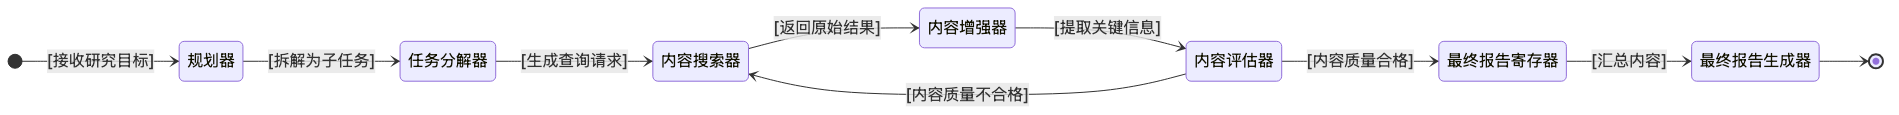

In [50]:
import subprocess, tempfile, os
from IPython.display import Image, display

mermaid_src = r"""
stateDiagram-v2
    direction LR
    [*] --> 规划器: [接收研究目标]
    规划器 --> 任务分解器: [拆解为子任务]
    任务分解器 --> 内容搜索器: [生成查询请求]
    内容搜索器 --> 内容增强器: [返回原始结果]
    内容增强器 --> 内容评估器: [提取关键信息]
    内容评估器 --> 内容搜索器: [内容质量不合格]
    内容评估器 --> 最终报告寄存器: [内容质量合格]
    最终报告寄存器 --> 最终报告生成器: [汇总内容]
    最终报告生成器 --> [*]
"""

with tempfile.TemporaryDirectory() as tmpdir:
    in_file  = os.path.join(tmpdir, "graph.mmd")
    out_file = os.path.join(tmpdir, "graph.png")
    with open(in_file, "w", encoding="utf-8") as f:
        f.write(mermaid_src)

    # 分辨率 ×2（3200×800）；数值可再调大
    subprocess.run(
        ["mmdc", "-i", in_file, "-o", out_file,
         "-b", "transparent", "-w", "3200", "-H", "800"],
        check=True
    )

    # notebook 中按 50% 缩放显示即可更清晰
    display(Image(out_file, width=1600))

In [51]:
!pip install -qU langgraph langchain langchain_openai langchain_community beautifulsoup4 tavily-python

In [52]:
import os
import re
from dotenv import load_dotenv
import operator
from typing import TypedDict, List, Annotated

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WebBaseLoader
from langgraph.graph import StateGraph, END
from langchain_core.documents import Document
load_dotenv()

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["OPENAI_API_BASE"] = os.getenv("OPENAI_API_BASE")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [53]:
class ResearchState(TypedDict):
    """
    代表我们研究图的状态。

    属性:
        current_date (str): 当前日期。
        research_goal (str): 初始的研究课题。
        plan (List[str]): 由规划器生成的子任务列表。
        queries (List[str]): 每个子任务的搜索查询列表。
        search_results (List[dict]): 来自搜索引擎的原始搜索结果。
        raw_documents (List[Document]): 从网页提取并生成摘要后的文档集合，包含来源信息。
        evaluated_documents (List[Document]): 由评估器批准的高质量文档集合。
        report (str): 最终的研究报告。
        eval_result (str): 内容评估器给出的结论 ("合格" 或 "不合格")
    """
    current_date: str
    research_goal: str
    plan: List[str]
    queries: List[str]
    search_results: List[dict]
    raw_documents: List[Document]
    evaluated_documents: List[Document]
    report: str
    eval_result: str # 显式添加评估结果

In [54]:
search_tool = TavilySearchResults(max_results=3)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind(max_tokens=3_000)

In [55]:
import tiktoken

ENC = tiktoken.encoding_for_model("gpt-4o-mini")   # 任何 gpt-4o 系列都行
MAX_TOKENS = 6_000                                  # 单次调用留出回复空间

def chunk_by_tokens(text: str, max_tokens: int = MAX_TOKENS):
    """把长文本按 token 数切片；返回字符串列表。"""
    tokens = ENC.encode(text)
    for i in range(0, len(tokens), max_tokens):
        yield ENC.decode(tokens[i:i + max_tokens])

In [56]:
def planner_node(state: ResearchState) -> dict:
    """规划器节点：将研究目标分解为计划"""
    print(">> [节点] 规划器: 正在生成研究计划...")
    prompt = ChatPromptTemplate.from_template(
        """
        你是一个专业的AI研究规划师。你的任务是为一个只能访问网络进行搜索的自动化代理制定研究计划。

        # 规则与限制:
        1.  计划必须清晰、可执行，并且每个步骤都能转化为一个或多个具体的网络搜索查询。
        2.  计划中不能包含任何需要物理操作、API访问权限或人类访谈的任务。
        3.  计划应包含3到5个核心步骤。
        4.  输出必须是一个Python列表的字符串格式，例如: ["步骤1", "步骤2", ...]。
        5.  今天是 {current_date}，请确保你的计划是基于这个日期的最新视角。

        # 用户研究目标: {research_goal}
        """
    )
    planner_chain = prompt | llm
    plan_string = planner_chain.invoke({"research_goal": state["research_goal"], "current_date": state["current_date"]}).content
    plan = [p for p in plan_string.split("\n") if p.strip()]
    print(f"   - 生成的计划: {plan}")
    return {"plan": plan}

def task_splitter_node(state: ResearchState) -> dict:
    """任务分解器节点：为每个计划步骤生成搜索查询"""
    print(">> [节点] 任务分解器: 正在生成搜索查询...")
    prompt = ChatPromptTemplate.from_template(
        """你是一个AI研究助理。
        请根据以下研究计划中的每个步骤，为其生成一个简洁、有效的搜索引擎查询语句。
        为每个步骤只生成一个查询。
        研究计划:
        {plan}
        
        以如下格式返回，每行一个查询:
        QUERY: [查询语句1]
        QUERY: [查询语句2]
        ..."""
    )
    splitter_chain = prompt | llm
    queries_string = splitter_chain.invoke({"plan": state["plan"]}).content
    queries = [q.replace("QUERY:", "").strip() for q in queries_string.split("\n") if "QUERY:" in q]
    print(f"   - 生成的查询: {queries}")
    return {"queries": queries}

def content_searcher_node(state: ResearchState) -> dict:
    """执行搜索并返回 *合法* URL 列表"""
    print(">> [节点] 内容搜索器: 正在执行网络搜索...")
    all_results = []
    
    URL_OK = re.compile(r"^https?://", re.IGNORECASE)

    for q in state["queries"]:
        for item in search_tool.invoke(q):
            # Tavily 既可能返回 str，也可能返回 dict
            if isinstance(item, str):
                url = item
            elif isinstance(item, dict):
                url = item.get("url", "")
            else:
                url = ""

            if URL_OK.match(url):            # 只保留 http / https
                all_results.append({"url": url})
            else:
                print(f"[过滤] 非法 URL 跳过: {url!r}")

    return {"search_results": all_results}

def content_enhancer_node(state: ResearchState) -> dict:
    """提取网页 → 分块摘要 → 返回 Document 列表"""
    print(">> [节点] 内容增强器: 正在提取网页内容并生成摘要...")

    urls = [r["url"] for r in state["search_results"]][:10]
    docs = WebBaseLoader(urls, continue_on_failure=True).load()

    # ➊ 单块 & 合流摘要链
    SUMMARY_PROMPT = ChatPromptTemplate.from_template(
        "请用中文在 150 词内摘要以下网页片段的关键信息：\n---\n{page}\n---"
    )
    summary_chain = SUMMARY_PROMPT | llm

    def summarize_long_html(html: str) -> str:
        """把超长 HTML 分块递归 summary→再 summary，防爆上下文"""
        # 一次最多送 6000 token，留足回复空间
        first_pass = [
            summary_chain.invoke({"page": chunk}).content.strip()
            for chunk in chunk_by_tokens(html, max_tokens=6000)
        ]
        # 如果分块 >1，再做一次总摘要
        if len(first_pass) > 1:
            joined = "\n\n".join(first_pass)
            return summary_chain.invoke({"page": joined}).content.strip()
        return first_pass[0]

    summarized_docs = []
    for doc in docs:
        try:
            summary = summarize_long_html(doc.page_content)
            summarized_docs.append(
                Document(page_content=summary, metadata=doc.metadata)
            )
        except Exception as e:
            # 某个网页失败就打印提醒并跳过，保证流程不断
            print(f"[跳过] {doc.metadata.get('source')} → {e}")

    return {"raw_documents": summarized_docs}

def content_evaluator_node(state: ResearchState) -> dict:
    """内容评估器节点：判断内容质量并决定下一步走向"""
    print(">> [节点] 内容评估器: 正在评估内容质量...")
    EVAL_PROMPT = ChatPromptTemplate.from_template(
        "判断下述摘要是否信息量充足、与研究目标相关。（只答 合格/不合格）\n研究目标: {goal}\n---\n摘要: {frag}\n---"
    )
    eval_chain = EVAL_PROMPT | llm

    votes = []
    # 从 state["raw_documents"] 中读取
    for doc in state["raw_documents"]:
        decision = eval_chain.invoke({
            "frag": doc.page_content, # 评估 page_content
            "goal": state["research_goal"]
        }).content.strip()
        votes.append("合格" in decision)

    result = "合格" if sum(votes) >= len(votes) * 0.6 else "不合格"
    print(f"   - 评估结果: {result}")
    return {"eval_result": result}

def report_register_node(state: ResearchState) -> dict:
    """最终报告寄存器节点：聚合高质量内容"""
    print(">> [节点] 最终报告寄存器: 内容质量合格，正在聚合...")
    # 将评估合格的 raw_documents 传递给 evaluated_documents
    return {"evaluated_documents": state["raw_documents"]}

def report_generator_node(state: ResearchState) -> dict:
    print(">> [节点] 报告生成器: 正在生成最终报告 (含参考文献)...")

    # --- 步骤 1: 生成参考文献列表和引文映射 ---
    evaluated_docs = state["evaluated_documents"]
    
    # 提取所有不重复的 URL
    unique_sources = sorted(list(set(doc.metadata['source'] for doc in evaluated_docs)))
    
    # 创建 URL 到引文编号的映射，例如: {"http://...": 1, "https://...": 2}
    source_map = {source: i + 1 for i, source in enumerate(unique_sources)}

    # --- 步骤 2: 准备带有引文标记的上下文 ---
    context_with_citations = []
    for doc in evaluated_docs:
        citation_num = source_map[doc.metadata['source']]
        # 将每个摘要和它的引文编号打包
        context_with_citations.append(f"[{citation_num}] {doc.page_content}")
    
    full_context = "\n\n".join(context_with_citations)

    # --- 步骤 3: 更新 Prompt，指导 LLM 使用引文 ---
    # 复用您原有的“提纲 -> 章节”逻辑，只需修改最终生成章节的提示
    outline_chain = (
        ChatPromptTemplate.from_template(
            "请基于下方资料列一个详细章节提纲（不少于 10 大点）：\n---\n{info}\n---"
        ) | llm
    )
    outline = outline_chain.invoke({"info": full_context}).content.split("\n")

    section_chain = (
        ChatPromptTemplate.from_template(
            "请根据“章节标题”和“参考资料”撰写 500 词左右的章节内容。\n"
            "**重要规则**: 在引用参考资料中的信息时，必须在句末使用对应的引用标记，例如 `[1]`, `[2]` 等。\n"
            "\n章节标题：{title}\n"
            "\n参考资料：\n{info}\n"
        ) | llm
    )
    
    sections = [
        section_chain.invoke({"title": title, "info": full_context}).content
        for title in outline if title.strip()
    ]

    report_body = "# 研究报告\n\n" + "\n\n".join(sections)

    # --- 步骤 4: 创建并附加参考文献部分 ---
    references_section = "\n\n---\n\n## 参考文献\n\n"
    for source, num in source_map.items():
        references_section += f"[{num}] {source}\n\n"
    
    final_report = report_body + references_section
    
    return {"report": final_report}


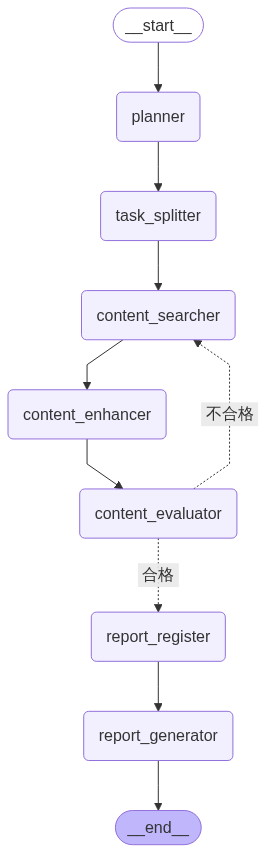

In [57]:
graph_builder = StateGraph(ResearchState)

# 添加所有节点
graph_builder.add_node("planner", planner_node)
graph_builder.add_node("task_splitter", task_splitter_node)
graph_builder.add_node("content_searcher", content_searcher_node)
graph_builder.add_node("content_enhancer", content_enhancer_node)
graph_builder.add_node("content_evaluator", content_evaluator_node)
graph_builder.add_node("report_register", report_register_node)
graph_builder.add_node("report_generator", report_generator_node)

# 设置入口点
graph_builder.set_entry_point("planner")

# 添加边
graph_builder.add_edge("planner", "task_splitter")
graph_builder.add_edge("task_splitter", "content_searcher")
graph_builder.add_edge("content_searcher", "content_enhancer")
graph_builder.add_edge("content_enhancer", "content_evaluator")

# 添加条件边，这是实现循环的关键
graph_builder.add_conditional_edges(
    "content_evaluator",
    lambda st: st["eval_result"],
    path_map={
        "合格": "report_register",
        "不合格": "content_searcher",
    },
)

graph_builder.add_edge("report_register", "report_generator")
graph_builder.add_edge("report_generator", END)

# 编译图，生成可执行的应用
app = graph_builder.compile()

from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [58]:
from pprint import pprint
import datetime

# 定义初始的研究目标
research_goal = "分析2025年人工智能在自动化编程（AI for Code）领域的发展趋势与挑战"
current_date = datetime.date.today().strftime("%Y年%m月%d日")

# 调用图，传入初始状态并开始执行
final_state = app.invoke({"research_goal": research_goal, "current_date": current_date})

# 打印最终生成的研究报告
print("\n" + "="*50)
print("最终研究报告")
print("="*50 + "\n")
print(final_state['report'])

>> [节点] 规划器: 正在生成研究计划...
   - 生成的计划: ['["搜索2025年人工智能在自动化编程领域的最新发展趋势", "查找2025年AI在代码生成中的应用案例", "研究2025年AI编程工具的市场竞争情况", "分析2025年AI在自动化编程中面临的主要挑战", "总结2025年人工智能在自动化编程领域的未来展望"]']
>> [节点] 任务分解器: 正在生成搜索查询...
   - 生成的查询: ['2025年人工智能 自动化编程 最新发展趋势', '2025年 AI 代码生成 应用案例', '2025年 AI 编程工具 市场竞争情况', '2025年 AI 自动化编程 主要挑战', '2025年 人工智能 自动化编程 未来展望']
>> [节点] 内容搜索器: 正在执行网络搜索...
>> [节点] 内容增强器: 正在提取网页内容并生成摘要...
>> [节点] 内容评估器: 正在评估内容质量...
   - 评估结果: 合格
>> [节点] 最终报告寄存器: 内容质量合格，正在聚合...
>> [节点] 报告生成器: 正在生成最终报告 (含参考文献)...

最终研究报告

# 研究报告

# 2025年人工智能发展趋势与应用研究提纲

随着科技的迅猛发展，人工智能（AI）在各个领域的应用不断深化，预计到2025年，AI将迎来一系列重要的发展趋势。这些趋势不仅将改变企业的运营模式，还将深刻影响人们的日常生活。

首先，**人工智能代理**的崛起将成为一个显著趋势。AI智能体将从概念阶段转向实际应用，能够自主处理复杂任务，提升企业效率。根据预测，超过15%的日常决策将由AI智能体自主完成，这标志着企业在决策过程中将越来越依赖于智能体的能力[2]。然而，尽管技术进步迅速，当前的智能体仍面临处理复杂场景的挑战，企业需要在技术和管理上做好准备，以实现智能体的有效应用。

其次，**超个性化**服务将成为企业增强客户体验的重要手段。通过定制化的AI服务，企业能够更好地满足客户的个性化需求，从而推动客户忠诚度的提升。这种趋势不仅体现在零售和电子商务领域，也将在医疗、教育等多个行业中得到广泛应用[1]。

在投资方面，企业将更加重视**投资回报率的衡量**。随着AI项目的增多，确保可衡量的价值将成为企业决策的重要依据。企业需要建立有效的评估机制，以

In [61]:
# 假设你已在上一步拿到 final_state
report_md = final_state["report"]          # 研究报告正文（已含 Markdown 语法）

# —— ① 保存为本地 .md 文件 ——
with open("v3_report.md", "w", encoding="utf-8") as f:
    print(report_md)
    f.write(report_md)

print("✅ 已输出 Markdown 文件：AI_for_Code_2025_Report.md")

# —— ② 在 Notebook 中直接渲染（可选） ——
# from IPython.display import Markdown, display
# display(Markdown(report_md))

# 研究报告

# 2025年人工智能发展趋势与应用研究提纲

随着科技的迅猛发展，人工智能（AI）在各个领域的应用不断深化，预计到2025年，AI将迎来一系列重要的发展趋势。这些趋势不仅将改变企业的运营模式，还将深刻影响人们的日常生活。

首先，**人工智能代理**的崛起将成为一个显著趋势。AI智能体将从概念阶段转向实际应用，能够自主处理复杂任务，提升企业效率。根据预测，超过15%的日常决策将由AI智能体自主完成，这标志着企业在决策过程中将越来越依赖于智能体的能力[2]。然而，尽管技术进步迅速，当前的智能体仍面临处理复杂场景的挑战，企业需要在技术和管理上做好准备，以实现智能体的有效应用。

其次，**超个性化**服务将成为企业增强客户体验的重要手段。通过定制化的AI服务，企业能够更好地满足客户的个性化需求，从而推动客户忠诚度的提升。这种趋势不仅体现在零售和电子商务领域，也将在医疗、教育等多个行业中得到广泛应用[1]。

在投资方面，企业将更加重视**投资回报率的衡量**。随着AI项目的增多，确保可衡量的价值将成为企业决策的重要依据。企业需要建立有效的评估机制，以便在AI投资中获得更高的回报[1]。

**生成式人工智能安全**也是一个不可忽视的趋势。随着网络安全威胁的增加，智能安全产品的快速发展将成为企业保护数据和信息安全的重要手段。企业需要在AI安全技术上进行投资，以应对日益复杂的网络环境[1]。

此外，**量子人工智能**的结合将为解决传统方法无法处理的复杂问题提供新的思路。量子计算与AI的结合有望在数据处理和分析方面实现质的飞跃，推动科学研究和技术创新的进程[1]。

在软件开发领域，**AI编程工具**的应用将显著提升开发效率。预计到2025年，AI生成的代码将占全球代码产出的41%。AI编程工具如GitHub Copilot等，能够根据开发者的需求自动生成完整的代码模块，降低了编程门槛，使非专业人员也能参与软件开发[3][5]。然而，实现完整代码生成仍面临挑战，如准确理解自然语言需求和处理复杂业务逻辑[8]。

最后，**人机协作**将成为未来AI发展的重要方向。AI与人类的合作将提升决策支持和创造力，推动各行业的创新与发展。公众对AI的理解和期望也在不断提升，期待AI能够在实际操作中带来更多的效益[1][4]。

综上所述，2025年人工智能的发展将

## 改进
1. 优化报告内容质量
2. 支持上传文档，外挂知识库
3. 用mcp调用各类工具